In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

### Test data x^3 + a x^2       a: [-1,3]

In [214]:
labels = np.linspace(-3,3,1000)
corr_labels = np.tile(labels, (6, 1)).T
# print(corr_labels[:,0])
x = np.linspace(-2,2,6)
corr_data = np.zeros((1000,6))
for i in range(len(corr_data)):
    corr_data[i] = x**3 - corr_labels[i,0]*x**2
# plt.plot(corr_data[100])
# plt.plot(corr_data[800])
corr_data += 5*np.random.uniform(-1,1, size=corr_data.shape)
# plt.plot(corr_data[100])
# plt.plot(corr_data[800])

## Proxy Correlation data

In [34]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

d = np.load("../wgplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
dat = {axis: d[axis] for axis in axes}
wgplusses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wgcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wgcrosses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wgg_data.npz")
wgg = np.array(d['wgg'])

corr_labels = np.vstack((label_table,label_table,label_table))
for i in range(corr_labels.shape[1]):
    if i>1:
        corr_labels[:,i] = np.log(corr_labels[:,i])
corr_data = wgplusses
print(corr_data.shape, corr_labels.shape)

(3000, 6) (3000, 6)


### ML Process with corr_data and corr_labels

In [35]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]

In [36]:
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[ 3.00000000e-01  8.00000000e-01 -9.40378495e-08 -9.40378495e-08
  5.16441936e-08  5.16441936e-08]
[0.11547    0.11547    0.8003771  0.8003771  0.40018833 0.40018833]
[1.84196419 0.58107442 0.20204337 0.10429877 0.05308822 0.01370463]
[2.84132872 0.92559248 0.32423855 0.17477564 0.10118084 0.09779046]


Text(0, 0.5, 'Frequency')

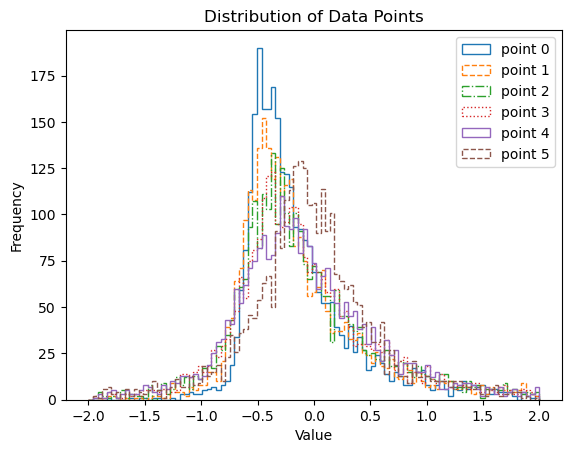

In [37]:
from cycler import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
for i in [0,1,2,3,4,5]:
    plt.hist(renorm_corrs[:,i], bins=np.linspace(-2,2,100),histtype=u'step', label=f'point {i}',linestyle=next(linecycler))
plt.legend()
plt.title('Distribution of Data Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

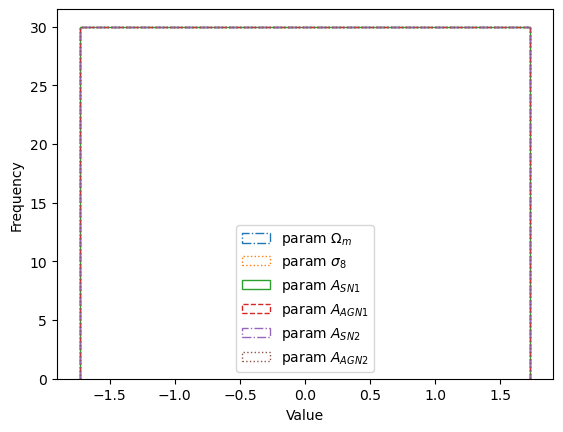

In [38]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
for i in range(6):
    plt.hist(renorm_labels[:,i], bins=100, histtype=u'step', label=f'param ${simpars[i]}$',linestyle=next(linecycler))
plt.legend()
# plt.title(f'Distribution of Label Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [39]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(2565, 6) (2565, 6)
(300, 6) (300, 6)
(135, 6) (135, 6)


#### Build Model

In [40]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               896       
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 8)                 264       
                                                                 
 dense_22 (Dense)            (None, 1)                 9         
                                                                 
Total params: 11505 (44.94 KB)
Trainable params: 11505 (44.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


10/10 [==============================] - 0s 434us/step
End validation loss is: 1.001176118850708


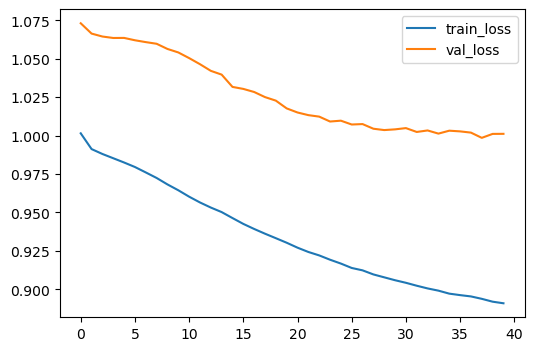

In [41]:
param=1
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=40,batch_size=100,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

10/10 [==============================] - 0s 674us/step


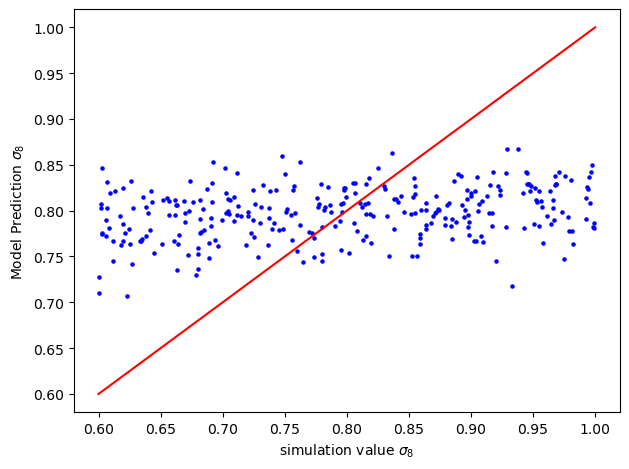

In [42]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
# plt.title('Testing Data')
plt.tight_layout()
# plt.axhline(0.5,c='k')

## DM corr data

In [28]:
# wgplussesDM_z = []
# wgcrossesDM_z = []
# ggsDM_z = []
# for i in range(0,700):
#     for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
#         dat = ascii.read(f)
#         if j == 0:
# #             print(dat.colnames)
# #             print(dat['meanr'])
#             r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
#         elif j == 1:
#             r, wgg = dat['rnom'], dat['wgg']
    
#     wgplussesDM_z.append(wgp)
#     wgcrossesDM_z.append(wgx)
#     ggsDM_z.append(wgg)
    
# label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
# corr_labels = label_table[:700]
# print(corr_labels.shape)

In [43]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

d = np.load("../wdplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
dat = {axis: d[axis] for axis in axes}
wdplusses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wdcrosses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdd_data.npz")
wdd = np.array(d['wgg'])

corr_labels = np.vstack((label_table,label_table,label_table))
for i in range(corr_labels.shape[1]):
    if i>1:
        corr_labels[:,i] = np.log(corr_labels[:,i])
corr_data = wdplusses
print(corr_data.shape, corr_labels.shape)

(3000, 7) (3000, 6)


In [44]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[ 3.00000000e-01  8.00000000e-01 -9.40378495e-08 -9.40378495e-08
  5.16441936e-08  5.16441936e-08]
[0.11547    0.11547    0.8003771  0.8003771  0.40018833 0.40018833]
[2.66103049 1.11153468 0.31856177 0.11926334 0.06025962 0.026045
 0.00285502]
[2.56825372 1.28928313 0.43669128 0.15925363 0.08216056 0.05123981
 0.07966836]


In [45]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(2565, 7) (2565, 6)
(300, 7) (300, 6)
(135, 7) (135, 6)


#### Build Model

In [48]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(7,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               1024      
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 8)                 520       
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13969 (54.57 KB)
Trainable params: 13969 (54.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


10/10 [==============================] - 0s 438us/step
End validation loss is: 0.7709721922874451


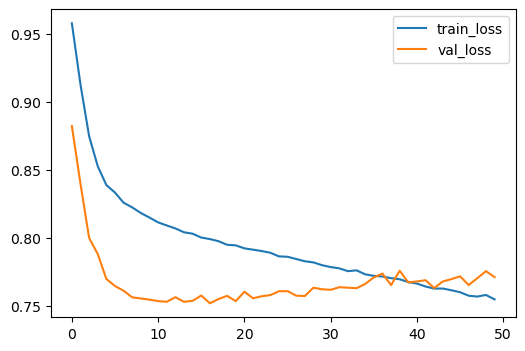

In [49]:
param=1
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=50,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

10/10 [==============================] - 0s 438us/step


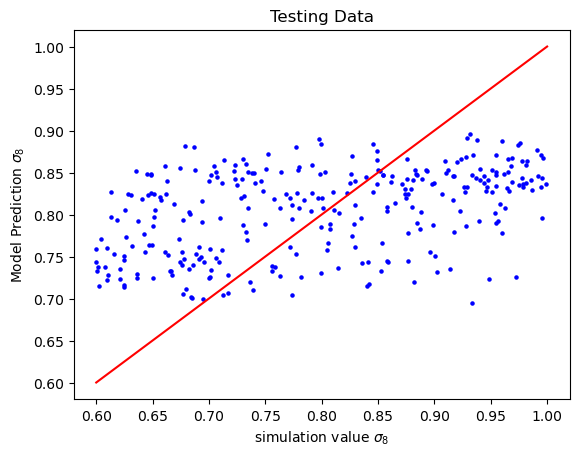

In [50]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
# plt.axhline(0.5,c='k')
#save
raw_sig8 = test_label_unorm 
raw_sig8_pred = test_predict 

### All Params at once

In [76]:
wgplussesDM_z = []
wgcrossesDM_z = []
ggsDM_z = []
for i in range(0,836):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplussesDM_z.append(wgp)
    wgcrossesDM_z.append(wgx)
    ggsDM_z.append(wgg)
    
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = label_table[:836]
print(corr_labels.shape)

(836, 6)


In [77]:
corr_data = np.array(wgplussesDM_z)

In [78]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[0.2973311  0.80030335 1.36177386 1.34773075 1.08975097 1.0820587 ]
[0.11534647 0.11528892 1.03600606 1.01531014 0.42713705 0.42393312]
[1.53370964 0.48690762 0.17109064 0.09025822 0.05171977 0.0112766 ]
[1.70404133 0.62286815 0.23229037 0.13758521 0.08270672 0.06390065]


In [79]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(714, 6) (714, 6)
(84, 6) (84, 6)
(38, 6) (38, 6)


#### Build Model

In [80]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(144, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(144, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(72, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
# model.add(tf.keras.layers.Dense(36, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(6, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 144)               1008      
                                                                 
 dense_25 (Dense)            (None, 144)               20880     
                                                                 
 dense_26 (Dense)            (None, 72)                10440     
                                                                 
 dense_27 (Dense)            (None, 6)                 438       
                                                                 
Total params: 32766 (127.99 KB)
Trainable params: 32766 (127.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


End validation loss is: 0.9576987028121948


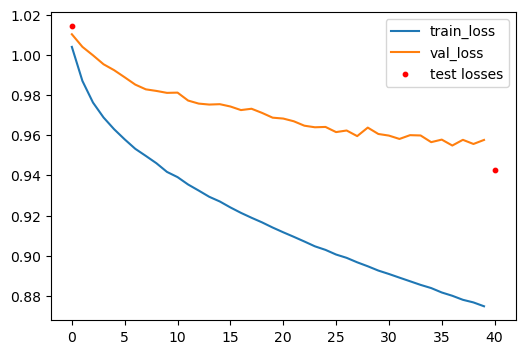

In [81]:
epochs=40
pre_loss = model.evaluate(test_data, test_label[:,:], verbose=0)
history=model.fit(train_data,train_label[:,:],epochs=epochs,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,:]))
loss = model.evaluate(test_data, test_label[:,:], verbose=0)

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.scatter([0,epochs],[pre_loss,loss],s=10,color='red',label='test losses')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

3/3 [==============================] - 0s 847us/step


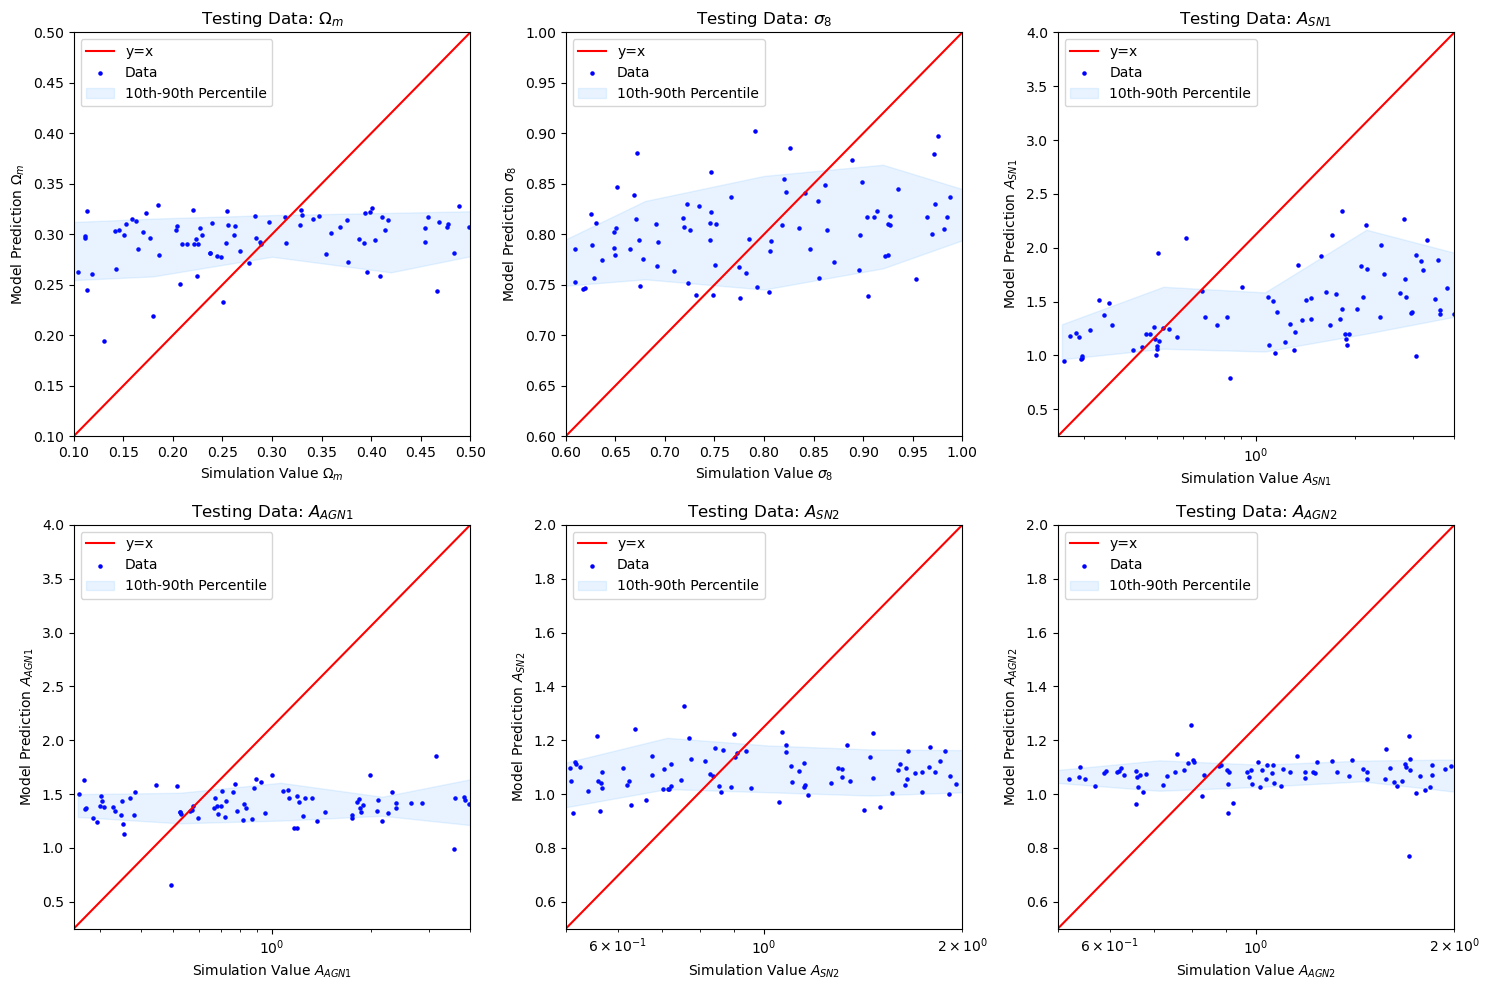

In [85]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]

test_predict = model.predict(test_data, verbose=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the array for easy indexing

for param in range(6):
    ax = axes[param]

    # Unnormalize 
    test_predict_param = test_predict[:, param] * std_labels[param] + mean_labels[param]
    test_label_unorm = test_label[:, param] * std_labels[param] + mean_labels[param]
        # percentile range
    if param>1:
        bins = np.logspace(np.log(lims[param][0]), np.log(lims[param][1]), 10) 
    else:
        bins = np.linspace(lims[param][0]-0.1, lims[param][1]+0.1, 6)  # Create  bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    percentiles_10 = []
    percentiles_90 = []

    # Calculate percentiles for each bin
    for i in range(len(bins) - 1):
        in_bin = (test_label_unorm >= bins[i]) & (test_label_unorm < bins[i + 1])
        if np.any(in_bin):  # If data exists in this bin
            percentiles_10.append(np.percentile(test_predict_param[in_bin], 10))
            percentiles_90.append(np.percentile(test_predict_param[in_bin], 90))
        else:
            percentiles_10.append(np.nan)
            percentiles_90.append(np.nan)
    
    # 
    ax.plot(lims[param], lims[param], c='r', label='y=x')
    ax.scatter(test_label_unorm, test_predict_param, s=5, color='blue', label='Data')
    ax.fill_between(
    bin_centers, percentiles_10, percentiles_90, color="dodgerblue", alpha=0.1, label="10th-90th Percentile")
    if param>1: ax.set_xscale('log')
    
    # Set labels, title, and limits
    ax.set_ylabel(f'Model Prediction ${simpars[param]}$')
    ax.set_xlabel(f'Simulation Value ${simpars[param]}$')
    ax.set_title(f'Testing Data: ${simpars[param]}$')
    ax.set_xlim(lims[param])
    ax.set_ylim(lims[param])
    ax.legend()

plt.tight_layout()
plt.show()

## $w_{\delta +}$/$w_{\delta \delta}$

(3000, 7) (3000, 6)


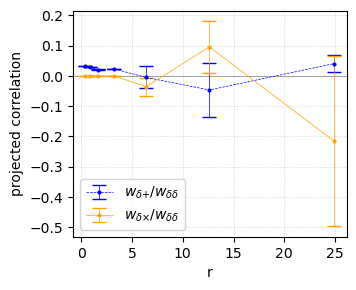

In [2]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

d = np.load("../wdplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
dat = {axis: d[axis] for axis in axes}
wdplusses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wdcrosses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdd_data.npz")
wdd = np.array(d['wgg'])

corr_labels = np.vstack((label_table,label_table,label_table))
for i in range(corr_labels.shape[1]):
    if i>1:
        corr_labels[:,i] = np.log(corr_labels[:,i])
corr_data = wdplusses/wdd
print(corr_data.shape, corr_labels.shape)
##### PLOT
sqrtN = np.sqrt(3000)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11/3,3))
ax.axhline(0,c='0.5',linewidth=0.5)
ax.errorbar(r,np.mean(corr_data,axis=0), yerr=np.std(corr_data,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'$w_{\delta{+}}/w_{\delta\delta}$', marker='o',markersize=2, color='blue')
ax.errorbar(r,np.mean(wdcrosses/wdd,axis=0), yerr=np.std(wdcrosses/wdd,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'$w_{\delta {\times}}/w_{\delta\delta}$', marker='o',markersize=2, color='orange')
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
#ax.set_ylim(-np.abs(ax.get_ylim()).max(), 0.4*np.abs(ax.get_ylim()).max())
# ax[0].set_title(r"LH (0 - 1000) average position-shape")
ax.set_xlabel("r")
ax.set_ylabel(r"projected correlation")
ax.legend()
fig.tight_layout()

In [20]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2
# split
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

[ 3.00000000e-01  8.00000000e-01 -9.40378495e-08 -9.40378495e-08
  5.16441936e-08  5.16441936e-08]
[0.11547    0.11547    0.8003771  0.8003771  0.40018833 0.40018833]
[ 1.68894266  1.34263684  0.97451445  0.78594317 -0.00246951 -0.00943174
  0.02718059]
[1. 1. 1. 1. 1. 1. 1.]
(2565, 7) (2565, 6)
(300, 7) (300, 6)
(135, 7) (135, 6)


#### Build Model

In [24]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(7,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               1024      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13969 (54.57 KB)
Trainable params: 13969 (54.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


End validation loss is: 1.053767204284668


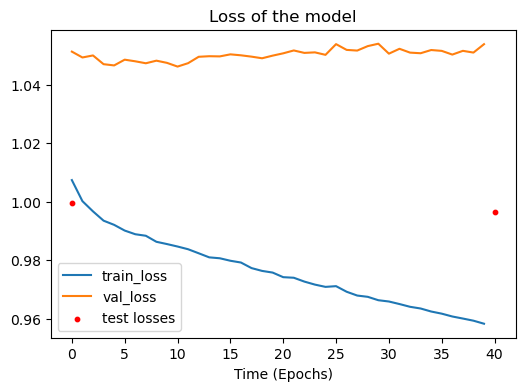

In [25]:
epochs=40; param = 4
pre_loss = model.evaluate(test_data, test_label[:, param], verbose=0)
history=model.fit(train_data,train_label[:,param],epochs=epochs,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,param]))
loss = model.evaluate(test_data, test_label[:, param], verbose=0)

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.scatter([0,epochs],[pre_loss,loss],s=10,color='red',label='test losses')
plt.title('Loss of the model')
ax.set_xlabel('Time (Epochs)')
ax.set_ylabel = 'Loss'
ax.legend()
plt.show()

10/10 [==============================] - 0s 410us/step - loss: 0.9965


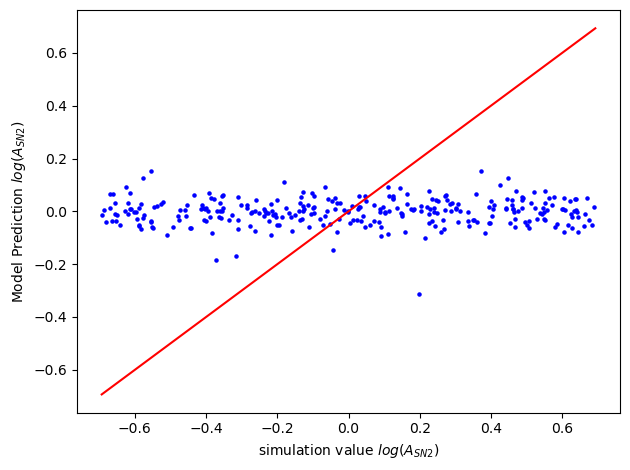

In [28]:
loss = model.evaluate(test_data, test_label[:, param], verbose=1)

simpars = ['\Omega_m','\sigma_8','log(A_{SN1})','log(A_{AGN1})','log(A_{SN2})','log(A_{AGN2})']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
test_predict=model.predict(test_data, verbose=0)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.tight_layout() # plt.title('Testing Data')
# plt.axhline(0.5,c='k')

Text(0.5, 1.0, '$w_{\\delta +}$ dep on $\\sigma_8$')

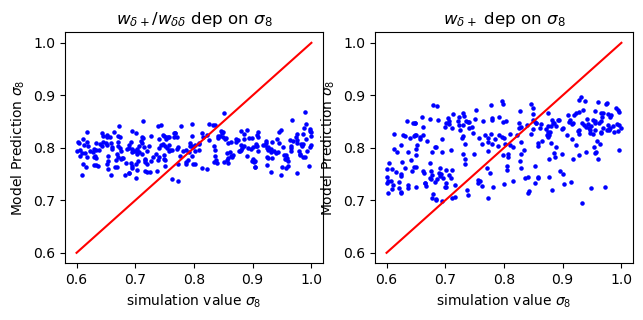

In [59]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(22/3,3))
ax[0].plot(lims[param],lims[param],c='r')
ax[0].scatter(test_label_unorm, test_predict,s=5, color='blue')
ax[0].set_ylabel(f'Model Prediction ${simpars[param]}$')
ax[0].set_xlabel(f'simulation value ${simpars[param]}$')
ax[0].set_title(r'$w_{\delta +}/w_{\delta \delta}$ dep on $\sigma_8$')

ax[1].plot(lims[param],lims[param],c='r')
ax[1].scatter(raw_sig8, raw_sig8_pred,s=5, color='blue')
ax[1].set_ylabel(f'Model Prediction ${simpars[param]}$')
ax[1].set_xlabel(f'simulation value ${simpars[param]}$')
ax[1].set_title(r'$w_{\delta +}$ dep on $\sigma_8$')


## $w_{\delta +}$/$w_{\delta \delta}$ For all params

In [60]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2
# split
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

[ 3.00000000e-01  8.00000000e-01 -9.40378495e-08 -9.40378495e-08
  5.16441936e-08  5.16441936e-08]
[0.11547    0.11547    0.8003771  0.8003771  0.40018833 0.40018833]
[ 0.03151451  0.02929236  0.02095021  0.02288657 -0.004884   -0.04641866
  0.04080338]
[0.01865931 0.02181704 0.0214981  0.02911988 1.9777203  4.9215364
 1.50119533]
(2565, 7) (2565, 6)
(300, 7) (300, 6)
(135, 7) (135, 6)


#### Build Model

In [63]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(144, input_shape=(7,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(144, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(72, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
# model.add(tf.keras.layers.Dense(36, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(6, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 144)               1152      
                                                                 
 dense_48 (Dense)            (None, 144)               20880     
                                                                 
 dense_49 (Dense)            (None, 72)                10440     
                                                                 
 dense_50 (Dense)            (None, 6)                 438       
                                                                 
Total params: 32910 (128.55 KB)
Trainable params: 32910 (128.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


End validation loss is: 0.886082649230957


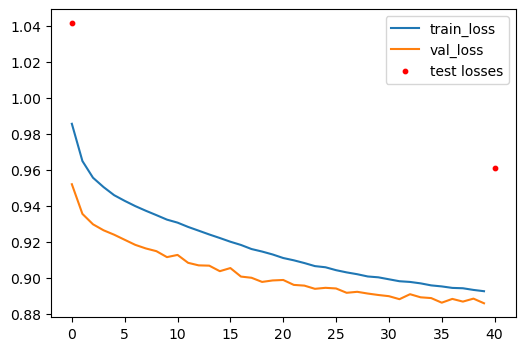

In [64]:
epochs=40
pre_loss = model.evaluate(test_data, test_label[:,:], verbose=0)
history=model.fit(train_data,train_label[:,:],epochs=epochs,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,:]))
loss = model.evaluate(test_data, test_label[:,:], verbose=0)

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.scatter([0,epochs],[pre_loss,loss],s=10,color='red',label='test losses')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

10/10 [==============================] - 0s 445us/step


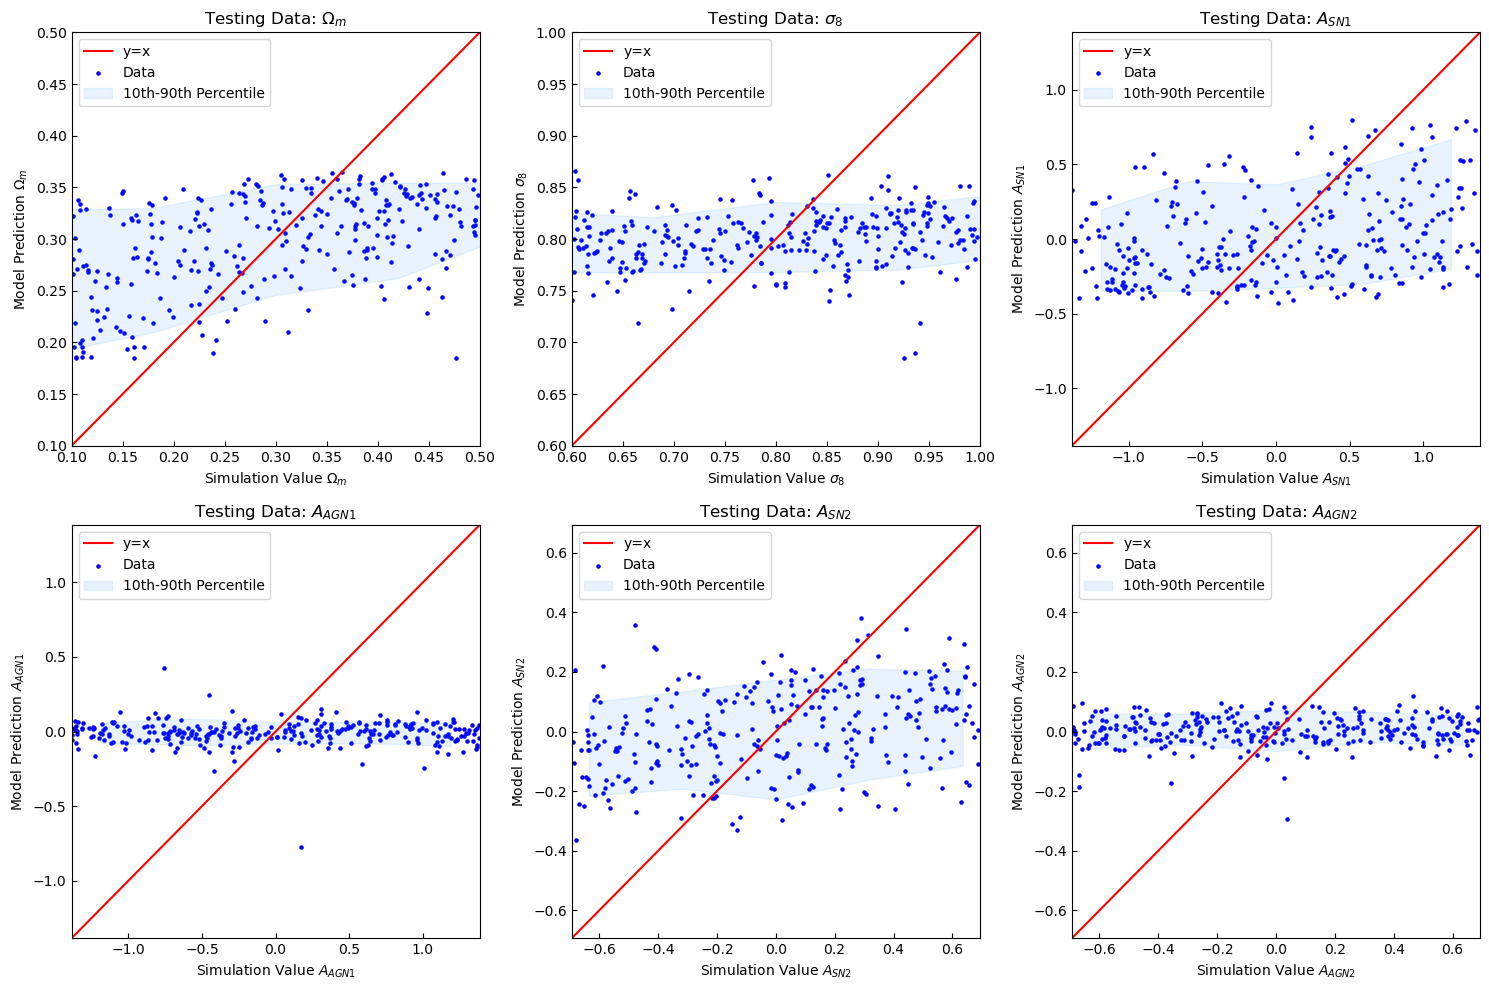

In [70]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]

test_predict = model.predict(test_data, verbose=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the array for easy indexing

for param in range(6):
    ax = axes[param]

    # Unnormalize 
    test_predict_param = test_predict[:, param] * std_labels[param] + mean_labels[param]
    test_label_unorm = test_label[:, param] * std_labels[param] + mean_labels[param]
        # percentile range

    bins = np.linspace(lims[param][0]-0.1, lims[param][1]+0.1, 6)  # Create  bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    percentiles_10 = []
    percentiles_90 = []

    # Calculate percentiles for each bin
    for i in range(len(bins) - 1):
        in_bin = (test_label_unorm >= bins[i]) & (test_label_unorm < bins[i + 1])
        if np.any(in_bin):  # If data exists in this bin
            percentiles_10.append(np.percentile(test_predict_param[in_bin], 10))
            percentiles_90.append(np.percentile(test_predict_param[in_bin], 90))
        else:
            percentiles_10.append(np.nan)
            percentiles_90.append(np.nan)
    
    # 
    ax.plot(lims[param], lims[param], c='r', label='y=x')
    ax.scatter(test_label_unorm, test_predict_param, s=5, color='blue', label='Data')
    ax.fill_between(
    bin_centers, percentiles_10, percentiles_90, color="dodgerblue", alpha=0.1, label="10th-90th Percentile")
#     if param>1: ax.set_xscale('log')
    
    # Set labels, title, and limits
    ax.set_ylabel(f'Model Prediction ${simpars[param]}$')
    ax.set_xlabel(f'Simulation Value ${simpars[param]}$')
    ax.set_title(f'Testing Data: ${simpars[param]}$')
    ax.set_xlim(lims[param])
    ax.set_ylim(lims[param])
    ax.tick_params(which='both', direction='in')
    ax.legend()

plt.tight_layout()
plt.show()

### Weighted $w_{\delta +}/w_{\delta \delta}$

In [2]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

d = np.load("../wdplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
dat = {axis: d[axis] for axis in axes}
wdplusses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdcross_data.npz")
dat = {axis: d[axis] for axis in axes}
wdcrosses = np.append(np.array(dat['x']), np.append(dat['y'],dat['z'],axis=0),axis=0)
d = np.load("../wdd_data.npz")
wdd = np.array(d['wgg'])

corr_labels = np.vstack((label_table,label_table,label_table))
for i in range(corr_labels.shape[1]):
    if i>1:
        corr_labels[:,i] = np.log(corr_labels[:,i])
corr_data = wdplusses/wdd
print(corr_data.shape, corr_labels.shape)

(3000, 7) (3000, 6)


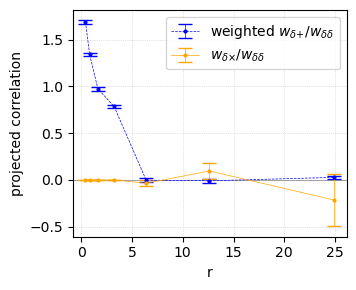

In [3]:
corr_data = wdplusses/wdd
weights = 1/np.std(corr_data,axis=0)
wtd_corr_data = corr_data*weights

sqrtN = np.sqrt(3000)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11/3,3))
ax.axhline(0,c='0.5',linewidth=0.5)
ax.errorbar(r,np.mean(wtd_corr_data,axis=0), yerr=np.std(wtd_corr_data,axis=0)/sqrtN, linewidth=0.5, linestyle='--', elinewidth=0.5
               , capsize=5 ,label=r'weighted $w_{\delta{+}}/w_{\delta\delta}$', marker='o',markersize=2, color='blue')
ax.errorbar(r,np.mean(wdcrosses/wdd,axis=0), yerr=np.std(wdcrosses/wdd,axis=0)/sqrtN, linewidth=0.5, elinewidth=0.5 
               , capsize=5,label=r'$w_{\delta {\times}}/w_{\delta\delta}$', marker='o',markersize=2, color='orange')
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
#ax.set_ylim(-np.abs(ax.get_ylim()).max(), 0.4*np.abs(ax.get_ylim()).max())
# ax[0].set_title(r"LH (0 - 1000) average position-shape")
ax.set_xlabel("r")
ax.set_ylabel(r"projected correlation")
ax.legend()
fig.tight_layout()

In [6]:
corr_data = wtd_corr_data # learning with the weighted corrs
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data)
std_corrs = np.std(corr_data)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2
# split
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.04, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

0.6867594954729298
1.190555074831325
(2592, 7) (2592, 6)
(300, 7) (300, 6)
(108, 7) (108, 6)


In [7]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(144, input_shape=(7,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(144, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(72, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
# model.add(tf.keras.layers.Dense(36, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(6, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 144)               1152      
                                                                 
 dense_1 (Dense)             (None, 144)               20880     
                                                                 
 dense_2 (Dense)             (None, 72)                10440     
                                                                 
 dense_3 (Dense)             (None, 6)                 438       
                                                                 
Total params: 32910 (128.55 KB)
Trainable params: 32910 (128.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


End validation loss is: 0.9801836609840393


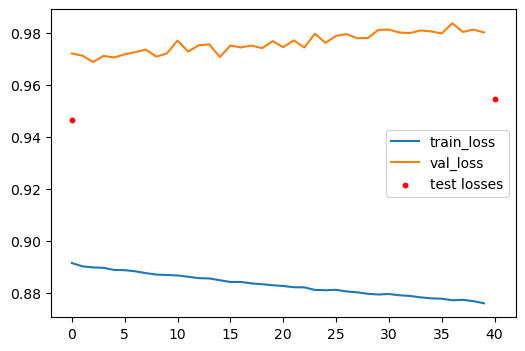

In [11]:
epochs=40
pre_loss = model.evaluate(test_data, test_label[:,:], verbose=0)
history=model.fit(train_data,train_label[:,:],epochs=epochs,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,:]))
loss = model.evaluate(test_data, test_label[:,:], verbose=0)

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.scatter([0,epochs],[pre_loss,loss],s=10,color='red',label='test losses')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

10/10 [==============================] - 0s 354us/step


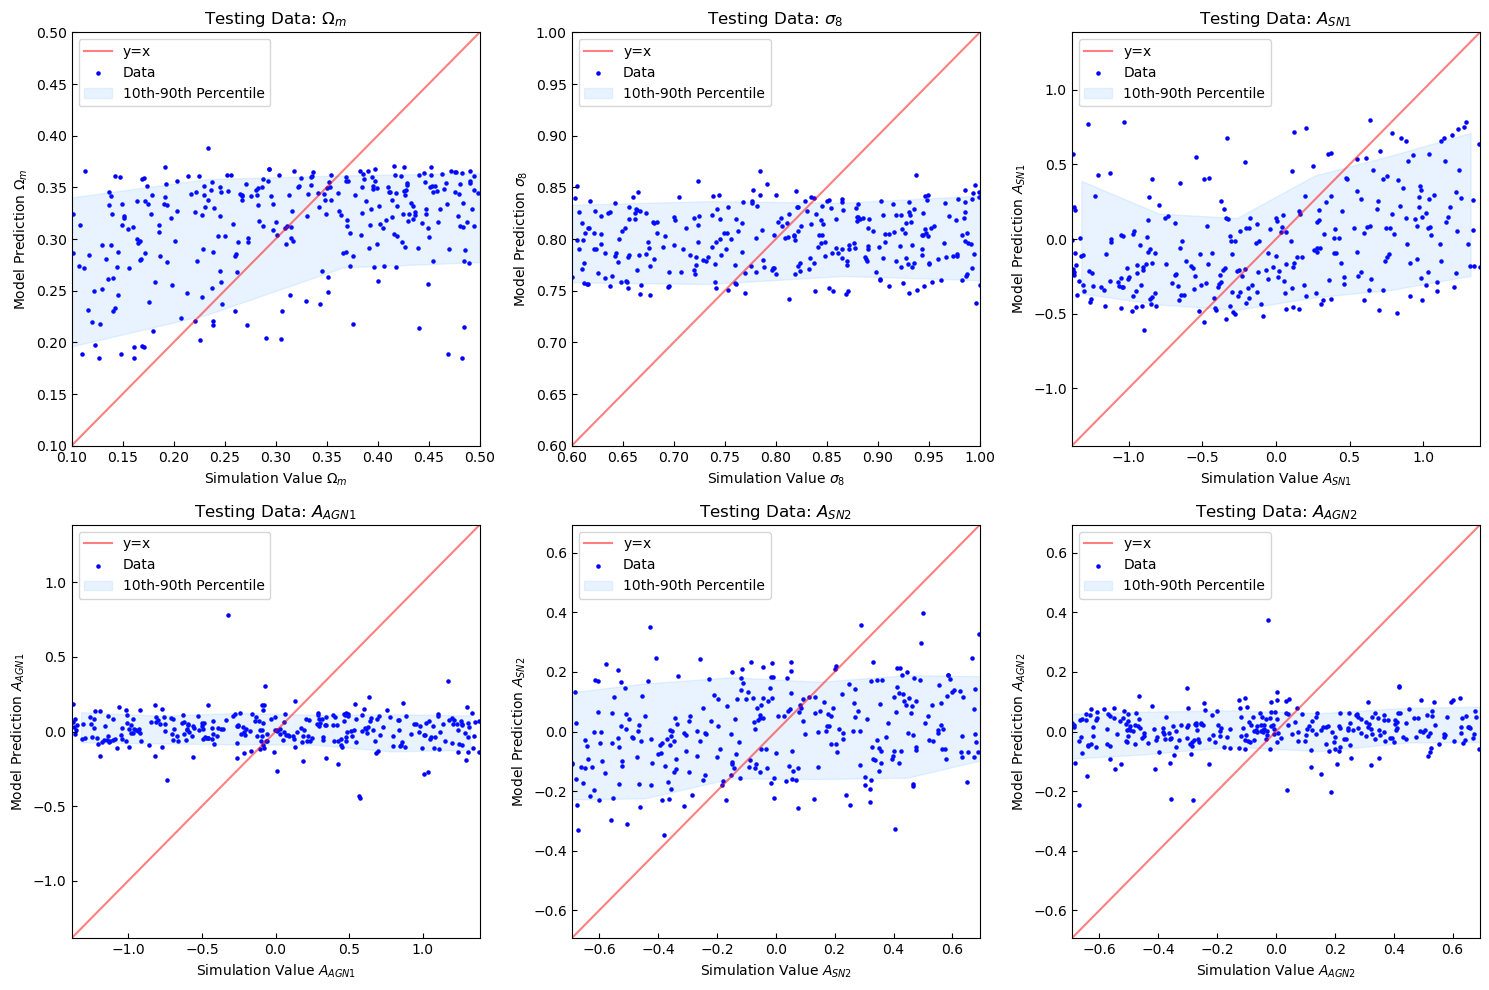

In [12]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]

test_predict = model.predict(test_data, verbose=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the array for easy indexing

for param in range(6):
    ax = axes[param]

    # Unnormalize 
    test_predict_param = test_predict[:, param] * std_labels[param] + mean_labels[param]
    test_label_unorm = test_label[:, param] * std_labels[param] + mean_labels[param]
        # percentile range

    bins = np.linspace(lims[param][0]-0.2, lims[param][1]+0.2, 7)  # Create  bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    percentiles_10 = []
    percentiles_90 = []

    # Calculate percentiles for each bin
    for i in range(len(bins) - 1):
        in_bin = (test_label_unorm >= bins[i]) & (test_label_unorm < bins[i + 1])
        if np.any(in_bin):  # If data exists in this bin
            percentiles_10.append(np.percentile(test_predict_param[in_bin], 10))
            percentiles_90.append(np.percentile(test_predict_param[in_bin], 90))
        else:
            percentiles_10.append(np.nan)
            percentiles_90.append(np.nan)
    
    # 
    ax.plot(lims[param], lims[param], c='r', label='y=x',alpha=0.5)
    ax.scatter(test_label_unorm, test_predict_param, s=5, color='blue', label='Data')
    ax.fill_between(
    bin_centers, percentiles_10, percentiles_90, color="dodgerblue", alpha=0.1, label="10th-90th Percentile")
#     if param>1: ax.set_xscale('log')
    
    # Set labels, title, and limits
    ax.set_ylabel(f'Model Prediction ${simpars[param]}$')
    ax.set_xlabel(f'Simulation Value ${simpars[param]}$')
    ax.set_title(f'Testing Data: ${simpars[param]}$')
    ax.set_xlim(lims[param])
    ax.set_ylim(lims[param])
    ax.tick_params(which='both', direction='in')
    ax.legend()

plt.tight_layout()
plt.show()

$\zeta$ $\xi$

## ML with PCA Components

In [61]:
wgplussesDM_z = []
wgcrossesDM_z = []
ggsDM_z = []
for i in range(0,836):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplussesDM_z.append(wgp)
    wgcrossesDM_z.append(wgx)
    ggsDM_z.append(wgg)
    
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = label_table[:836]
corr_data = wgplussesDM_z
print(corr_labels.shape)

(836, 6)


In [62]:
from sklearn.decomposition import PCA

# Apply PCA to corr_data
pca = PCA(n_components=3)  # Choose the number of components to retain
corr_data_pca = pca.fit_transform(corr_data)  # Transformed data in PCA space

In [63]:
# shuffle
num_samples = corr_data_pca.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data_pca = corr_data_pca[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data_pca,axis=0)
std_corrs = np.std(corr_data_pca,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data_pca-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2
# split
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

[0.2973311  0.80030335 1.36177386 1.34773075 1.08975097 1.0820587 ]
[0.11534647 0.11528892 1.03600606 1.01531014 0.42713705 0.42393312]
[ 1.20371549e-15 -1.41342613e-16 -1.80261839e-16]
[1.78092861 0.37867146 0.19759429]
(714, 3) (714, 6)
(84, 3) (84, 6)
(38, 3) (38, 6)


In [64]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(144, input_shape=(3,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(144, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(72, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
# model.add(tf.keras.layers.Dense(36, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(6, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 144)               576       
                                                                 
 dense_17 (Dense)            (None, 144)               20880     
                                                                 
 dense_18 (Dense)            (None, 72)                10440     
                                                                 
 dense_19 (Dense)            (None, 6)                 438       
                                                                 
Total params: 32334 (126.30 KB)
Trainable params: 32334 (126.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


End validation loss is: 1.0189001560211182


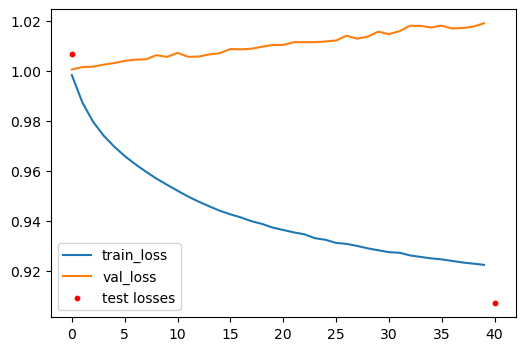

In [65]:
epochs=40
pre_loss = model.evaluate(test_data, test_label[:, :], verbose=0)
history=model.fit(train_data,train_label[:,:],epochs=epochs,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,:]))
loss = model.evaluate(test_data, test_label[:, :], verbose=0)

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.scatter([0,epochs],[pre_loss,loss],s=10,color='red',label='test losses')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

3/3 [==============================] - 0s 1ms/step


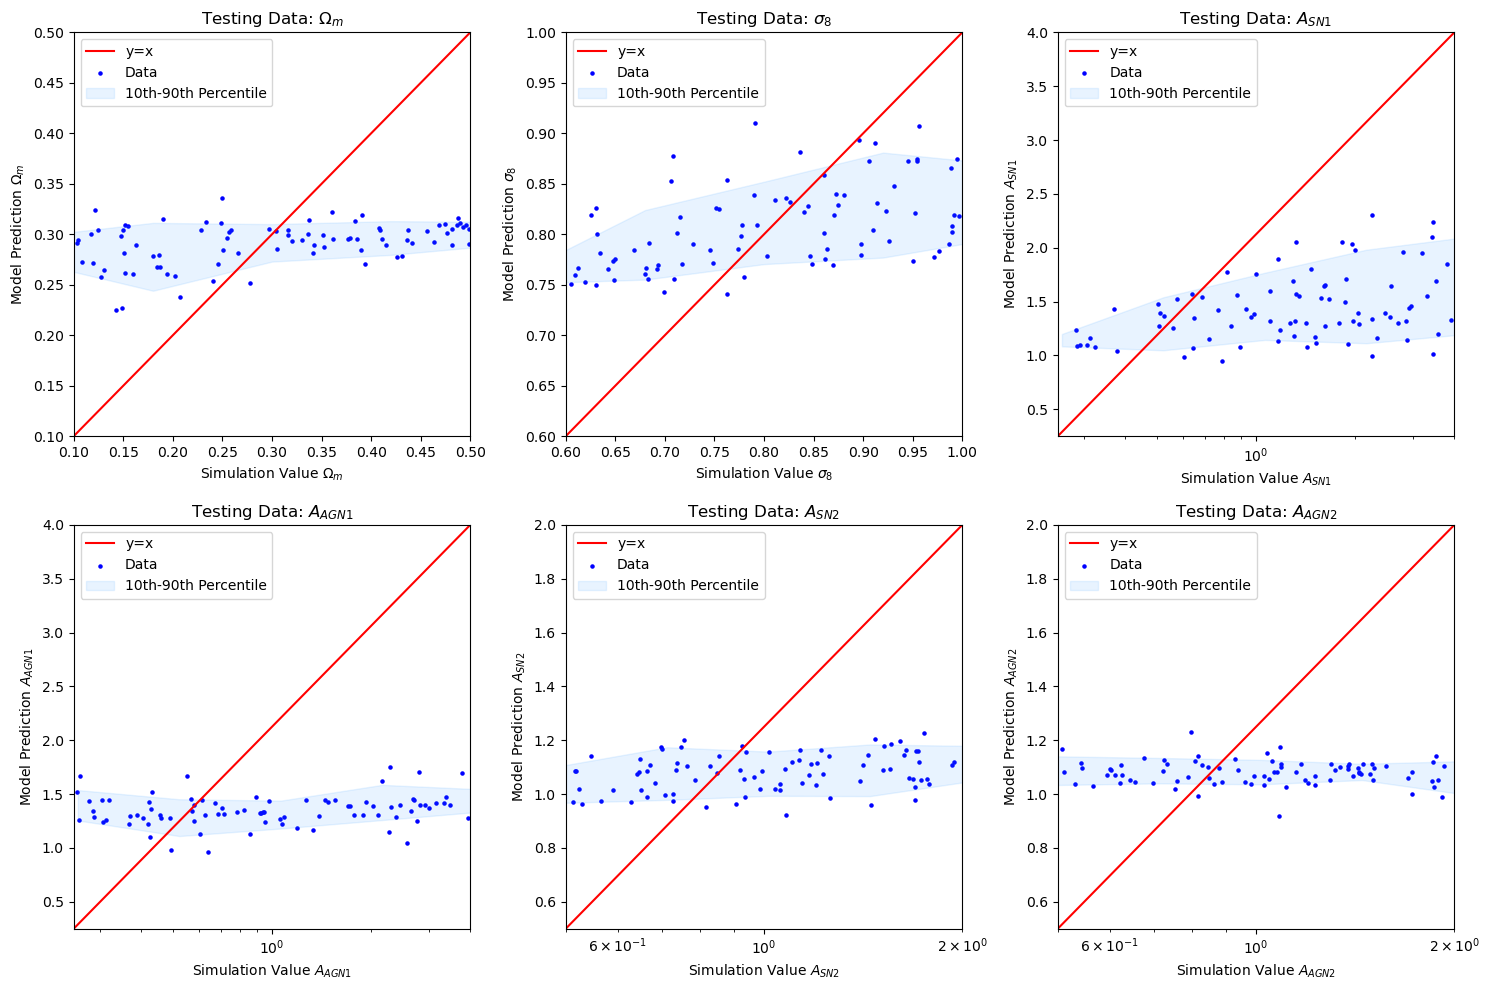

In [67]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]

test_predict = model.predict(test_data, verbose=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the array for easy indexing

for param in range(6):
    ax = axes[param]
    # Unnormalize 
    test_predict_param = test_predict[:, param] * std_labels[param] + mean_labels[param]
    test_label_unorm = test_label[:, param] * std_labels[param] + mean_labels[param]
    # percentile range
    if param>1:
        bins = np.logspace(np.log(lims[param][0]), np.log(lims[param][1]), 10) 
    else:
        bins = np.linspace(lims[param][0]-0.1, lims[param][1]+0.1, 6)  # Create  bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    percentiles_10 = []
    percentiles_90 = []

    # Calculate percentiles for each bin
    for i in range(len(bins) - 1):
        in_bin = (test_label_unorm >= bins[i]) & (test_label_unorm < bins[i + 1])
        if np.any(in_bin):  # If data exists in this bin
            percentiles_10.append(np.percentile(test_predict_param[in_bin], 10))
            percentiles_90.append(np.percentile(test_predict_param[in_bin], 90))
        else:
            percentiles_10.append(np.nan)
            percentiles_90.append(np.nan)

    # 
    ax.plot(lims[param], lims[param], c='r', label='y=x')
    ax.scatter(test_label_unorm, test_predict_param, s=5, color='blue', label='Data')
    ax.fill_between(
    bin_centers, percentiles_10, percentiles_90, color="dodgerblue", alpha=0.1, label="10th-90th Percentile")
    if param>1: ax.set_xscale('log')
    
    # Set labels, title, and limits
    ax.set_ylabel(f'Model Prediction ${simpars[param]}$')
    ax.set_xlabel(f'Simulation Value ${simpars[param]}$')
    ax.set_title(f'Testing Data: ${simpars[param]}$')
    ax.set_xlim(lims[param])
    ax.set_ylim(lims[param])
    ax.legend()

plt.tight_layout()
plt.show()

#### trying with PyTorch

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np


In [38]:
param=0
# Convert the data to PyTorch tensors
X_train = torch.tensor(train_data, dtype=torch.float32)
y_train = torch.tensor(train_label[:, param], dtype=torch.float32)

X_val = torch.tensor(val_data, dtype=torch.float32)
y_val = torch.tensor(val_label[:, param], dtype=torch.float32)

X_test = torch.tensor(test_data, dtype=torch.float32)
y_test = torch.tensor(test_label[:, param], dtype=torch.float32)


In [39]:
class LargerCorrelationModel(nn.Module):
    def __init__(self):
        super(LargerCorrelationModel, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
        
        # Dropout layers to reduce overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.relu(self.fc3(x))
        x = self.dropout(torch.relu(self.fc4(x)))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [40]:
model = LargerCorrelationModel()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [41]:
num_epochs = 200
best_val_loss = float('inf')
patience, patience_counter = 100, 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.flatten(), y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.flatten(), y_val)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter > patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/200], Loss: 0.9992, Val Loss: 1.0816
Epoch [20/200], Loss: 0.9951, Val Loss: 1.0890
Epoch [30/200], Loss: 0.9934, Val Loss: 1.0898
Epoch [40/200], Loss: 0.9921, Val Loss: 1.0883
Epoch [50/200], Loss: 0.9911, Val Loss: 1.0882
Epoch [60/200], Loss: 0.9856, Val Loss: 1.0891
Epoch [70/200], Loss: 0.9785, Val Loss: 1.0924
Epoch [80/200], Loss: 0.9711, Val Loss: 1.0972
Epoch [90/200], Loss: 0.9621, Val Loss: 1.1033
Epoch [100/200], Loss: 0.9542, Val Loss: 1.1021
Early stopping on epoch 106


In [42]:
# Load the best model based on validation loss
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.flatten(), y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 1.0095


/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_33181/982689432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.p

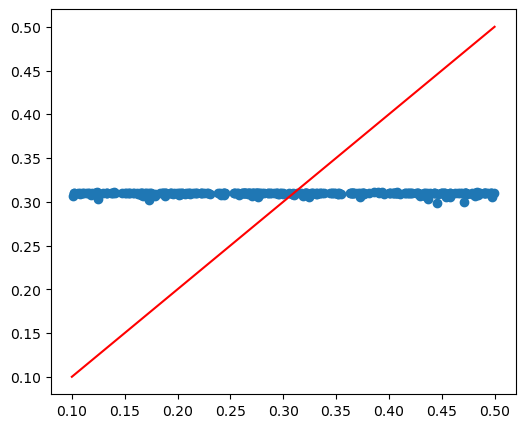

In [43]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]


model_guess = model(X_test).flatten().detach().numpy() * std_labels[param] + mean_labels[param]
correct_labels = y_test * std_labels[param] + mean_labels[param]

plt.figure(figsize=(6,5))
plt.plot(lims[param],lims[param],c='r')
plt.scatter(correct_labels, model_guess)